#### У даних присутня колонка Category та колонка Message. Category має в собі значення spam та ham, де spam – небажані повідомлення, ham – бажані повідомлення (у даному датасеті частина ham повина б бути заблокована та відправлена в спам після кількості незензурної лексики, але вже є факт, що це не рекламні пропозиції, тому не є спамом у нашому контексті). 
#### У даній лабораторній роботі основні кроки – це натренерувати embedding, створити рекурентну нейронну мережу, спробувати покращити результати різними способами, проаналізувати процес навчання та вплив (його відсутність) від покращень

#### блок з потрібними imports

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from nltk import download
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from collections import Counter, defaultdict 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from gensim.models import Word2Vec, KeyedVectors
from ast import literal_eval

### Підготовка даних для входу в мережу

#### Завантажимо дані по спам повідомленням (SPAM text message 20170820 - Data.csv)

In [3]:
df = pd.read_csv ('/Users/sofiialukashevych/Desktop/masters 2nd year/SPAM text message 20170820 - Data.csv')

In [52]:
display(df)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
category_counts = df['Category'].value_counts()

ham_count = category_counts.get('ham', 0)
spam_count = category_counts.get('spam', 0)

print('Ham count:', ham_count)
print('Spam count:', spam_count)

Ham count: 4825
Spam count: 747


Закодуємо категоріальні дані, де smap буде 1, ham – 0.

In [5]:
category_mapping = {'ham': 0, 'spam': 1}

In [6]:
df['Category'] = df['Category'].map(category_mapping)

In [56]:
display(df)

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [7]:
category_counts = df['Category'].value_counts()

ham_count = category_counts.get(0, 0)
spam_count = category_counts.get(1, 0)

print('Ham count:', ham_count)
print('Spam count:', spam_count)

Ham count: 4825
Spam count: 747


Спробуємо прибрати: слова, що мають мало впливу, пунктуацію. 
Також зробимо кожне повідомлення масивом слів.

In [8]:
for pkg in ['omw-1.4', 'punkt', 'stopwords', 'wordnet']:
    download(pkg)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sofiialukashevych/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sofiialukashevych/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sofiialukashevych/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sofiialukashevych/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))

Для цього запишему функцію, яка токенезує слова, виявляє пунктуацію, лематизує (зводить до кореню) слова.

In [10]:
def preprocess_text(tokenizer, lemmatizer, stop_words, punctuation, text): 
    tokens = tokenizer(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return [token for token in lemmas if token not in stop_words and token not in punctuation]

In [11]:
df['Message_modified'] = df['Message'].apply(
    lambda x: preprocess_text(word_tokenize, lemmatizer, stop_words, punctuation, x)
)

In [62]:
display(df)

,Category,Message,Message_modified
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, .., available, bugi..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, ..., u, c, already, ..."
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, n't, think, go, usf, life, around, though]"
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,"[2nd, time, tried, 2, contact, u., u, £750, po..."
5568,0,Will ü b going to esplanade fr home?,"[ü, b, going, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...","[pity, wa, mood, ..., suggestion]"
5570,0,The guy did some bitching but I acted like i'd...,"[guy, bitching, acted, like, 'd, interested, b..."


Розібʼємо дані на тестові та тренувальні.

In [12]:
n_ham = len(df[df['Category'] == 0])
n_ham

4825

In [13]:
n_spam = len(df[df['Category'] == 1])
n_spam

747

виправимо inbalance між spam та ham за допомогою ресемплінгу.
спроба використати class weights підхід не завершилась успіхом через технічні проблеми мого компʼютера, почали зʼявлятися ерор, повʼязані з оболонкою (zshell).
було обрано варіант undersampling, варто зазначити, що це є дуже грубий варіант виправлення такої ситуації, в ідеалі краще усе ж таки використати class weights підхід.
але подивимось, до чого призведе такий вибір.

In [14]:
n_spam_df = df[df['Category'] == 1]
n_ham_df = df[df['Category'] == 0].sample(n=spam_count, random_state=42)


undersampled_df = pd.concat([n_spam_df, n_ham_df])

undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

undersampled_category_counts = undersampled_df['Category'].value_counts()
undersampled_ham_count = undersampled_category_counts.get(0, 0)
undersampled_spam_count = undersampled_category_counts.get(1, 0)

print('Undersampled Ham count:', undersampled_ham_count)
print('Undersampled Spam count:', undersampled_spam_count)

Undersampled Ham count: 747
Undersampled Spam count: 747


In [119]:
undersampled_df

,Category,Message,Message_modified
0,0,The evo. I just had to download flash. Jealous?,"[evo, download, flash, jealous]"
1,0,Hi Dear Call me its urgnt. I don't know whats ...,"[hi, dear, call, urgnt, n't, know, whats, prob..."
2,0,Full heat pa:-) i have applyed oil pa.,"[full, heat, pa, applyed, oil, pa]"
3,0,Gokila is talking with you aha:),"[gokila, talking, aha]"
4,0,"Dude u knw also telugu..thts gud..k, gud nyt..","[dude, u, knw, also, telugu, .., thts, gud, ....."
...,...,...,...
1489,0,Ya srsly better than yi tho,"[ya, srsly, better, yi, tho]"
1490,0,I'm coming home 4 dinner.,"['m, coming, home, 4, dinner]"
1491,0,"I'm there and I can see you, but you can't see...","['m, see, ca, n't, see, maybe, reboot, ym, see..."
1492,0,Sent me ur email id soon,"[sent, ur, email, id, soon]"


In [15]:
n_ham_new = len(undersampled_df[undersampled_df['Category'] == 0])
n_ham_new

747

In [16]:
n_spam_new = len(undersampled_df[undersampled_df['Category'] == 1])
n_spam_new

747

In [17]:
np.random.seed(0)
n = n_ham_new
n_test = n // 10
n_test

74

In [18]:
test_ham = np.random.choice(
    np.arange(0, n_ham_new), size=(n_test // 2), replace=False
)

In [19]:
test_spam = np.random.choice(
    n_ham_new + np.arange(0, n_spam_new), size=(n_test // 2), replace=False
)

In [126]:
undersampled_df.iloc[test_ham][['Message_modified', 'Category']]

,Message_modified,Category
258,"[tomorrow, onwards, eve, 6, 3, work]",0
521,"[wylie, update, weed, dealer, carlos, went, fr...",0
14,"[congrats, 1, year, special, cinema, pas, 2, c...",1
31,"[wo, n't, believe, 's, true, 's, incredible, t...",1
505,"[collect, valentine, 's, weekend, paris, inc, ...",1
79,"[dear, voucher, holder, claim, week, offer, pc...",1
382,"[g, say, never, answer, text, confirm/deny]",0
75,"[want, new, nokia, 3510i, colour, phone, deliv...",1
471,"[came, look, flat, seems, ok, 50, away, alot, ...",0
27,"[r, giving, second, chance, rahul, dengra]",0


In [127]:
undersampled_df.iloc[test_spam][['Message_modified', 'Category']]

,Message_modified,Category
1447,"[private, 2004, account, statement, 078498, 7,...",1
756,"[cd, 4u, congratulation, ur, awarded, £500, cd...",1
1126,"[except, chick, huge, boob]",0
801,"[monthly, password, wap, mobsi.com, 391784., u...",1
1438,"[sunshine, quiz, wkly, q, win, top, sony, dvd,...",1
1115,"[ok, lor, ...]",0
1483,"[fantasy, football, back, tv, go, sky, gamesta...",1
938,"[get, 3, lion, england, tone, reply, lionm, 4,...",1
1187,"[forced, eat, slice, 'm, really, hungry, tho, ...",0
974,"[opinion, 1., 2., jada, 3., kusruthi, 4., lova...",0


In [20]:
np.random.seed(12345)

test = np.append(test_ham, test_spam)
np.random.shuffle(test)
test

array([ 505,  951,  400,    8,  938,   14, 1331,  862, 1443,  974,  250,
        337, 1424,  157,  603,  772, 1453,  497, 1360, 1300,   27,  338,
       1224, 1310,  215, 1134, 1411,  631,  382, 1369,  283, 1172, 1115,
        583,  113, 1447,  753,  801,  471, 1238, 1187,  873, 1232, 1279,
        718,   79,   31,  939,  258,  966, 1386,   55,  568,  655, 1291,
        230, 1126, 1483,   75,  756,  385,  457,  641,  522,  367,   40,
        829, 1308, 1406,  669, 1438,  702,  521,  333])

In [21]:
df_train = undersampled_df.drop(index=test, axis=0).sample(frac=1)
df_test = undersampled_df.iloc[test]

In [130]:
df_test.shape

(74, 3)

In [131]:
df_test[['Message_modified', 'Category']].head()

,Message_modified,Category
505,"[collect, valentine, 's, weekend, paris, inc, ...",1
951,"[boltblue, tone, 150p, reply, poly, mono, eg, ...",1
400,"[haha, awesome, might, need, take, doin, tonight]",0
8,"[sppok, ur, mob, halloween, collection, nokia,...",1
938,"[get, 3, lion, england, tone, reply, lionm, 4,...",1


In [132]:
df_train.shape

(1420, 3)

In [133]:
df_train[['Message_modified', 'Category']].head()

,Message_modified,Category
1077,"[ur, awarded, city, break, could, win, £200, s...",1
751,"[jus, chillaxin]",0
278,"[lmao, nice, 1]",0
709,"[romantic, paris, 2, night, 2, flight, £79, bo...",1
1152,"[look, like, found, something, smoke, great, job]",0


створимо словник

In [22]:
def flat_nested(y):
    flatten = []
    for x in y:
        if isinstance(x, list):
            flatten.extend(x)
        else:
            flatten.append(x)
    return flatten

In [23]:
vocabular = set(flat_nested(df_train['Message_modified'].tolist()))

Поглянемо на часто "вживані" слова у словнику, щоб зрозуміти його якість

In [24]:
cnt_vocab = Counter(flat_nested(df_train['Message_modified'].tolist()))

In [136]:
cnt_vocab.most_common(50)

[('call', 379),
 ('u', 277),
 ('free', 215),
 ('2', 203),
 ('ur', 168),
 ('...', 168),
 ('txt', 153),
 ('text', 143),
 ("'s", 138),
 ('mobile', 133),
 ('get', 128),
 ('4', 126),
 ('stop', 120),
 ('..', 115),
 ('reply', 105),
 ('claim', 105),
 ('c', 95),
 ('new', 86),
 ('prize', 85),
 ('send', 84),
 ('service', 70),
 ('tone', 68),
 ('go', 67),
 ("n't", 66),
 ('day', 64),
 ("'m", 64),
 ('phone', 64),
 ('nokia', 64),
 ('week', 63),
 ('cash', 60),
 ('please', 60),
 ('want', 60),
 ('win', 59),
 ('urgent', 58),
 ('message', 56),
 ('know', 55),
 ('ha', 54),
 ('contact', 53),
 ('min', 53),
 ('lt', 52),
 ('time', 51),
 ('gt', 51),
 ('today', 50),
 ('customer', 50),
 ('r', 49),
 ('wa', 49),
 ('guaranteed', 46),
 ('number', 46),
 ('good', 45),
 ('per', 45)]

In [137]:
cnt_vocab.most_common()[-50:-1]

[('dp', 1),
 ('bcm', 1),
 ('8027', 1),
 ('tarot', 1),
 ('85555', 1),
 ('olympics', 1),
 ('09090900040', 1),
 ('extreme', 1),
 ('dirty', 1),
 ('total', 1),
 ('privacy', 1),
 ('sic', 1),
 ('60p', 1),
 ('24/7mp', 1),
 ('0870753331018+', 1),
 ('hottest', 1),
 ('wanting', 1),
 ('07801543489', 1),
 ('no:83355', 1),
 ('tc-llc', 1),
 ('ny-usa', 1),
 ('150p/mt', 1),
 ('msgrcvd18+', 1),
 ('n-gage', 1),
 ('deck', 1),
 ('www.cnupdates.com/newsletter', 1),
 ('32000', 1),
 ('legitimat', 1),
 ('efreefone', 1),
 ('outbid', 1),
 ('simonwatson5120', 1),
 ('shinco', 1),
 ('plyr', 1),
 ('ac/smsrewards', 1),
 ('notification', 1),
 ('install', 1),
 ('browse', 1),
 ('artist', 1),
 ('wined', 1),
 ('dined', 1),
 ('www.gamb.tv', 1),
 ('09061701939.', 1),
 ('s89', 1),
 ('messages-text', 1),
 ('web2mobile', 1),
 ('txt250.com', 1),
 ('1.50p/wk', 1),
 ('box139', 1),
 ('la32wu', 1)]

Бачимо, що є точки, окремі букви, лапки і тд

Побудуємо більш "чистий" словник

In [25]:
threshold_count = 1
threshold_len = 2
cleaned_vocabular = list()
for token, count in cnt_vocab.items():
    if count > threshold_count and len(token) > threshold_len:
        cond_digit = not any(c.isdigit() for c in token)
        cond_punct = token[0] not in punctuation
        
        if cond_digit and cond_punct:
            cleaned_vocabular.append(token)

In [26]:
def sequence_cleaner(s, voc):
    res = [sj for sj in s if sj in voc]
    return res

df_train['Message_filtered'] = df_train['Message_modified'].apply(lambda u: sequence_cleaner(u, cleaned_vocabular))
df_test['Message_filtered'] = df_test['Message_modified'].apply(lambda u: sequence_cleaner(u, cleaned_vocabular))

/var/folders/4b/b3hx73cj4fzcm29xwvlsn2j80000gn/T/ipykernel_78591/3951361505.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Message_filtered'] = df_test['Message_modified'].apply(lambda u: sequence_cleaner(u, cleaned_vocabular))


In [247]:
df_train['Message_filtered'][df_train['Message_filtered'].apply(lambda u: len(u)) == 0]

1126    []
Name: Message_filtered, dtype: object

In [249]:
df_train[['Message_modified', 'Message_filtered', 'Category']].head()

,Message_modified,Message_filtered,Category
0,"[ur, awarded, city, break, could, win, £200, s...","[awarded, city, break, could, win, summer, sho...",1
1,"[jus, chillaxin]",[jus],0
2,"[lmao, nice, 1]","[lmao, nice]",0
3,"[romantic, paris, 2, night, 2, flight, £79, bo...","[night, flight, book, next, year, call, apply]",1
4,"[look, like, found, something, smoke, great, job]","[look, like, found, something, smoke, great, job]",0


In [141]:
df_test[['Message_modified', 'Message_filtered', 'Category']].head()

,Message_modified,Message_filtered,Category
505,"[collect, valentine, 's, weekend, paris, inc, ...","[collect, valentine, weekend, inc, flight, hot...",1
951,"[boltblue, tone, 150p, reply, poly, mono, eg, ...","[tone, reply, poly, mono, yeah, come, stop, to...",1
400,"[haha, awesome, might, need, take, doin, tonight]","[haha, awesome, might, need, take, doin, tonight]",0
8,"[sppok, ur, mob, halloween, collection, nokia,...","[mob, halloween, collection, nokia, logo, pic,...",1
938,"[get, 3, lion, england, tone, reply, lionm, 4,...","[get, england, tone, reply, mono, poly, www.ri...",1


ситуація покращилась.
треба зазначити, що самі повідомлення були написани у casual стилі, а не у професійному. тому могла залишитись частина притаманних носіям мови скорочень.
також варто уточнити, запропонований підхід до перетворення речення на токени є дещо грубим, бо ріже зв'язки, які частково базуються на тих самих частках (was, dont, does, etc). але основний сенс речення можна передати навіть у такому випадку, хоч і грубо.

### Побудуємо рекурентну нейронну мережу з власним шаром вкладення слів.

In [27]:
torch.manual_seed(12345)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Поки спробуємо на cpu, може 10-ти штук вистачить.

In [29]:
#копія чистого словнику, щоб не перероблювати його наново при можливих невдалих змінах надалі
vocabulary_main = cleaned_vocabular.copy()
vocabulary_main.append(' ')

WORD_TO_IDX = {WORD: IDX for IDX, WORD in enumerate(vocabulary_main)}

def vectorize(s, word_map):
    sequence_lengths = list(map(len, s))
    max_length = max(sequence_lengths)
    
    s_idx = np.zeros([len(s), max_length]) + word_map.get('', 0)

    for j in range(len(s)):
        line_idx = [word_map[w] for w in s[j] if w in word_map]
        s_idx[j, :len(line_idx)] = line_idx

    return s_idx, sequence_lengths

In [30]:
class BaseRNN(nn.Module):
    #метод ініціалізації для класу BaseRNN
    def __init__(self, vocab_size, embedding_size, hidden_size):
        #виклик конструктора parent класу
        super(self.__class__, self).__init__()
         #створення шару вбудовування з вказаним розміром словника та розміром вбудовування
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        #cтворення шару RNN з розміром вводу (розмір вбудовування) та розміром прихованого стану
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        #cтворення лінійного шару з розміром вводу (розмір прихованого стану) та розміром виводу 1
        self.linear = nn.Linear(hidden_size, 1)  
        #cтворення функції активації Sigmoid
        self.sigmoid = nn.Sigmoid()
        
    #метод forward, який визначає обчислення під час проходження вперед    
    def forward(self, x, sequences_lengths):
        #передача текстової послідовності
        embedding = self.embedding(x)
        #упаковування вбудованої послідовності на основі вказаних довжин послідовностей
        pack = torch.nn.utils.rnn.pack_padded_sequence(
            embedding, sequences_lengths, 
            batch_first=True, enforce_sorted=False
        )
        #передача упакованої послідовності через шар RNN (залучення рекурентної компоненти)
        all_hidden_states, hidden = self.rnn(pack)
        #забір даних з з RNN-компоненти у шар
        from_linear = self.linear(hidden)
        #прогноз класифікації повідомлення
        output = self.sigmoid(from_linear)
        return output

In [31]:
#ініціалізація моделі
model = BaseRNN(
    vocab_size=len(vocabulary_main), embedding_size=500, hidden_size=200
)
model.to(device)

BaseRNN(
  (embedding): Embedding(1416, 500)
  (rnn): RNN(500, 200, batch_first=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [32]:
epoch_loss_values = []
step_loss_values = []

In [33]:
#функція вартості (loss function)
loss_function = nn.BCELoss()
#оптимізато ADAM
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [34]:
batch_size = 50
n_epochs = 50
n_train = df_train.shape[0]
n_iters = n_train // batch_size

In [35]:
n_tab = str(len(str(n_epochs)))

In [36]:
#цикл по епохам
for epoch in range(n_epochs):
    #ініціалізація суми втрат для кожної епохи
    epoch_loss = 0 
    
    #створення копії навчального набору даних, його перетасовка та скидання індексу
    df_train_c = df_train.copy().sample(n_train).reset_index(drop=True)
    
    #цикл по ітераціях у межах епохи
    for step in range(n_iters):
        
        #"обнулення" (make zero) градієнтів для підготовки до нової ітерації
        optimizer.zero_grad()
        #обчислення індексів для поточного пакету в тренувальних даних
        idx = np.arange(0, batch_size, 1) + batch_size * step
        current_batch = df_train_c.iloc[idx]

        #векторизація повідомлень у поточному пакеті
        #отримання довжин послідовностей
        batch_idx, seq_lengths = vectorize(current_batch['Message_filtered'].tolist(), WORD_TO_IDX)
        if any(length <= 0 for length in seq_lengths):
            continue
        seq_lengths = np.array(seq_lengths)
        #конвертація індексів пакета в тензор PyTorch та переміщення на cpu
        batch_idx = torch.tensor(batch_idx, dtype=torch.int64).to(device)

        #отримання справжніх (true) міток для поточного пакета та конвертація в тензор PyTorch
        y_true = current_batch['Category'].tolist() 
        y_true = torch.tensor(y_true, dtype=torch.float).to(device)

        #підраххунок передбачень
        y_pred = model(batch_idx, seq_lengths)
        
        #обчислення втрат між спрогнозованими та справжніми мітками
        loss = loss_function(y_pred.squeeze(), y_true)
        
        #значення втрат для поточного кроку до списку
        step_loss_values.append(loss)
        
        #збір разом втрат для епохи
        epoch_loss += loss.item() / n_iters
        #обчислення градієнтів та оновлення параметрів моделі
        loss.backward()
        optimizer.step()
    
    epoch_loss_values.append(epoch_loss)
    
    #виведення номера епохи та загальних втрат для епохи
    print(('epoch {:' + n_tab + '}: epoch_loss: {}').format(epoch+1, epoch_loss))    

epoch  1: epoch_loss: 0.23434042770947727
epoch  2: epoch_loss: 0.1099913114947932
epoch  3: epoch_loss: 0.07013509528977531
epoch  4: epoch_loss: 0.027429279804761918
epoch  5: epoch_loss: 0.024663378850423863
epoch  6: epoch_loss: 0.012508450707952893
epoch  7: epoch_loss: 0.02812455581235034
epoch  8: epoch_loss: 0.034070822676377635
epoch  9: epoch_loss: 0.03130581969993987
epoch 10: epoch_loss: 0.01475262289334621
epoch 11: epoch_loss: 0.00781803548202983
epoch 12: epoch_loss: 0.005799249238667211
epoch 13: epoch_loss: 0.0030353473100279056
epoch 14: epoch_loss: 0.004542175077533882
epoch 15: epoch_loss: 0.000738083353748412
epoch 16: epoch_loss: 0.0008549904076582088
epoch 17: epoch_loss: 0.00048250326134231206
epoch 18: epoch_loss: 0.00040634994885684647
epoch 19: epoch_loss: 0.0007544440450146795
epoch 20: epoch_loss: 0.0005649714403261896
epoch 21: epoch_loss: 0.0003774994708822175
epoch 22: epoch_loss: 0.0002792663963191444
epoch 23: epoch_loss: 0.0001317840485301401
epoch 24

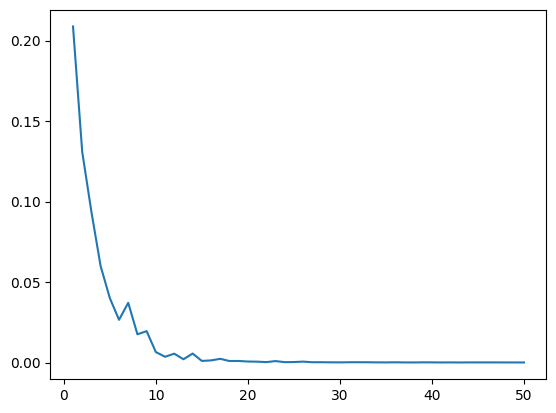

In [188]:
plt.plot(np.arange(1, n_epochs + 1), epoch_loss_values)
plt.show()

In [37]:
#функція для генерації індексів, які вказують на межі частин
def index_marks(nrows, chunk_size):
    #генерація діапазонів індексів
    return range(1 * chunk_size, (nrows // chunk_size + 1) * chunk_size, chunk_size)

In [38]:
#функція для розбиття датафрейму на частини на основі вказаного розміру частини
def split(df, chunk_size):
    #генерація індексів
    indices = index_marks(df.shape[0], chunk_size)
    #розбиття датафрейму за допомогою згенерованих індексів
    s = np.split(df, indices)
    #видалення пустої останньої частини (якзо вона є)
    if s[-1].empty:
        return s[:-1]
    return s

In [42]:
#функція для прогнозування за допомогою моделі
def make_predictions(model, df_test, batch_size, threshold, prints_b = True): 
    #лічильник для виведення прогнозів
    n_prints = 0
    #списки для збереження справжніх (true) міток та прогнозів
    predictions = []
    true_labels = []
    #розбиття тестових даних на міні-пакети
    test_batches = split(df_test, batch_size)
    
    #ітерація по міні-пакетам тестових даних
    for batch in test_batches:
        #векторизація повідомлень у міні-пакеті
        batch_ix, seq_lengths = vectorize(batch['Message_filtered'].tolist(), WORD_TO_IDX)
        if any(length <= 0 for length in seq_lengths):
            continue
        seq_lengths = np.array(seq_lengths)
        #перетворення у тензор  міні-пакетів 
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

        #отримання справжніх категорій спам(1)/хам(0) для міні-пакету
        y_true = batch['Category'].tolist()

        #прогнозування
        y_pred = model(batch_ix, seq_lengths).cpu().detach().squeeze().numpy()
        y_pred = [int(pred.item() > threshold) for pred in y_pred]
        
        #додавання справжніх міток та прогнозів до відповідних списків
        predictions.extend(y_pred)
        true_labels.extend(y_true)
        
        #виведення прогнозів та відгуків
        if prints_b:
            for true, pred, document in zip(y_true, y_pred, batch['Message']):
                if true == 1.0 and n_prints < 10:
                    print("prediction: {}".format(pred))
                    print("truth: {}".format(true))
                    print("message contains: {}".format(document))
                    print("\n" + "/////////////////////////////" + "\n")
                    n_prints += 1
        
    return true_labels, predictions

In [43]:
true_labels, predictions = make_predictions(model, df_test, batch_size=batch_size, threshold=0.5)

prediction: 1
truth: 1
message contains: Collect your VALENTINE'S weekend to PARIS inc Flight & Hotel + £200 Prize guaranteed! Text: PARIS to No: 69101. www.rtf.sphosting.com

/////////////////////////////

prediction: 1
truth: 1
message contains: Boltblue tones for 150p Reply POLY# or MONO# eg POLY3 1. Cha Cha Slide 2. Yeah 3. Slow Jamz 6. Toxic 8. Come With Me or STOP 4 more tones txt MORE

/////////////////////////////

prediction: 1
truth: 1
message contains: Sppok up ur mob with a Halloween collection of nokia logo&pic message plus a FREE eerie tone, txt CARD SPOOK to 8007

/////////////////////////////

prediction: 1
truth: 1
message contains: Get 3 Lions England tone, reply lionm 4 mono or lionp 4 poly. 4 more go 2 www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply

/////////////////////////////

prediction: 1
truth: 1
message contains: Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc a

Матриця якості класифікації (test data):

In [209]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.96      0.96      0.96        24

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

0.96


In [44]:
true_labels, predictions = make_predictions(model, df_train, batch_size=batch_size, threshold=0.5)

prediction: 1
truth: 1
message contains: UR awarded a City Break and could WIN a £200 Summer Shopping spree every WK. Txt STORE to 88039.SkilGme.TsCs087147403231Winawk!Age16+£1.50perWKsub

/////////////////////////////

prediction: 1
truth: 1
message contains: Romantic Paris. 2 nights, 2 flights from £79 Book now 4 next year. Call 08704439680Ts&Cs apply.

/////////////////////////////

prediction: 1
truth: 1
message contains: For ur chance to win a £250 wkly shopping spree TXT: SHOP to 80878. T's&C's www.txt-2-shop.com custcare 08715705022, 1x150p/wk

/////////////////////////////

prediction: 1
truth: 1
message contains: PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call 08719899230 Identifier Code: 41685 Expires 07/11/04

/////////////////////////////

prediction: 1
truth: 1
message contains: Welcome to UK-mobile-date this msg is FREE giving you free calling to 08719839835. Future mgs billed at 150p daily. To cancel send "go stop" to 89123

/////////

Матриця якості класифікації (train data):

In [211]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       375
           1       1.00      1.00      1.00       395

    accuracy                           1.00       770
   macro avg       1.00      1.00      1.00       770
weighted avg       1.00      1.00      1.00       770

1.0


100% точність на тренувальних даних може бути ознакою перенавчання.
Модель надто добре адаптується до тренувальних даних і може не так ефективно генералізуватися на нові дані.
Можна спробувати додати у модель компоненту довготривалої пам'яті LSTM та подивитись як це може вплинути на результати.

In [45]:
class BaseLSTM(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(self.__class__, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size, 
                            hidden_size=hidden_size, 
                            num_layers=1, 
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(2 * hidden_size, 1)      
        self.sigmoid = nn.Sigmoid()
        
        self.hidden_size = hidden_size
        
    def forward(self, x, sequences_lengths):
        embedding = self.embedding(x)

        pack = torch.nn.utils.rnn.pack_padded_sequence(
            embedding, sequences_lengths, 
            batch_first=True, enforce_sorted=False
        )
        
        packed_out, _ = self.lstm(pack)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(
            packed_out, batch_first=True
        )
        
        out_fwd = out[range(len(out)), sequences_lengths - 1, :self.hidden_size]
        out_rev = out[:, 0, self.hidden_size:]
        out_red = torch.cat((out_fwd, out_rev), 1)
        
        from_linear = self.linear(out_red)
        output = self.sigmoid(from_linear)
        return output

In [46]:
model = BaseLSTM(
    vocab_size=len(vocabulary_main), embedding_size=250, hidden_size=100
)
model.to(device)

BaseLSTM(
  (embedding): Embedding(1416, 250)
  (lstm): LSTM(250, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [47]:
epoch_loss_values = []
step_loss_values = []

In [48]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [49]:
batch_size = 50
n_epochs = 50
n_train = df_train.shape[0]
n_iters = n_train // batch_size

In [50]:
n_tab = str(len(str(n_epochs)))

In [51]:
for epoch in range(n_epochs):
    epoch_loss = 0 
    
    df_train_c = df_train.copy().sample(n_train).reset_index(drop=True)
    
    for step in range(n_iters):

        optimizer.zero_grad()
        idx = np.arange(0, batch_size, 1) + batch_size * step
        current_batch = df_train_c.iloc[idx]

        batch_idx, seq_lengths = vectorize(current_batch['Message_filtered'].tolist(), WORD_TO_IDX)
        if any(length <= 0 for length in seq_lengths):
            continue 
        seq_lengths = np.array(seq_lengths)
        batch_idx = torch.tensor(batch_idx, dtype=torch.int64).to(device)
        
        y_true = current_batch['Category'].tolist() 
        y_true = torch.tensor(y_true, dtype=torch.float).to(device)

        y_pred = model(batch_idx, seq_lengths)
        
        loss = loss_function(y_pred.squeeze(), y_true)
        
        step_loss_values.append(loss)

        epoch_loss += loss.item() / n_iters
        loss.backward()
        optimizer.step()
    
    epoch_loss_values.append(epoch_loss)
            
    print(('epoch {:' + n_tab + '}: epoch_loss: {}').format(epoch+1, epoch_loss))  

epoch  1: epoch_loss: 0.2124579006007739
epoch  2: epoch_loss: 0.07855466274278505
epoch  3: epoch_loss: 0.05671641031014068
epoch  4: epoch_loss: 0.03282972388634725
epoch  5: epoch_loss: 0.017458195831360563
epoch  6: epoch_loss: 0.010487077624670098
epoch  7: epoch_loss: 0.004182079241478018
epoch  8: epoch_loss: 0.003435008996997827
epoch  9: epoch_loss: 0.0012076652700281037
epoch 10: epoch_loss: 0.001498935602804912
epoch 11: epoch_loss: 0.0007908184634288772
epoch 12: epoch_loss: 0.0004086740165283638
epoch 13: epoch_loss: 0.0004525074670839656
epoch 14: epoch_loss: 0.0003108373701771988
epoch 15: epoch_loss: 0.0003211298457504849
epoch 16: epoch_loss: 0.0002588239346680763
epoch 17: epoch_loss: 0.00016395541076365456
epoch 18: epoch_loss: 0.0001421858030101118
epoch 19: epoch_loss: 0.0002047262751148082
epoch 20: epoch_loss: 0.00013307827248354445
epoch 21: epoch_loss: 0.00011355544640017407
epoch 22: epoch_loss: 0.00012486378273024457
epoch 23: epoch_loss: 0.000102376824023459

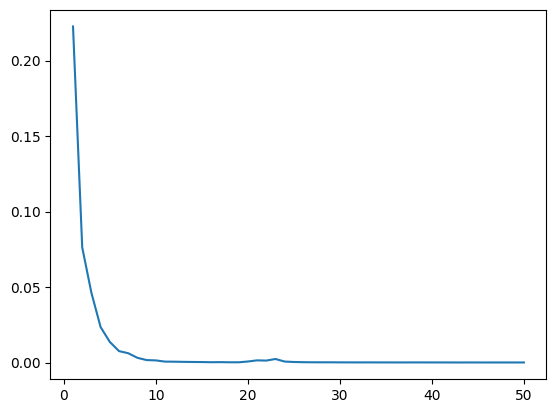

In [219]:
plt.plot(np.arange(1, n_epochs + 1), epoch_loss_values)
plt.show()

In [52]:
true_labels, predictions = make_predictions(model, df_test, batch_size=batch_size, threshold=0.5)

prediction: 1
truth: 1
message contains: Collect your VALENTINE'S weekend to PARIS inc Flight & Hotel + £200 Prize guaranteed! Text: PARIS to No: 69101. www.rtf.sphosting.com

/////////////////////////////

prediction: 1
truth: 1
message contains: Boltblue tones for 150p Reply POLY# or MONO# eg POLY3 1. Cha Cha Slide 2. Yeah 3. Slow Jamz 6. Toxic 8. Come With Me or STOP 4 more tones txt MORE

/////////////////////////////

prediction: 1
truth: 1
message contains: Sppok up ur mob with a Halloween collection of nokia logo&pic message plus a FREE eerie tone, txt CARD SPOOK to 8007

/////////////////////////////

prediction: 1
truth: 1
message contains: Get 3 Lions England tone, reply lionm 4 mono or lionp 4 poly. 4 more go 2 www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply

/////////////////////////////

prediction: 1
truth: 1
message contains: Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc a

In [222]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.92      0.92      0.92        24

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50

0.92


In [53]:
true_labels, predictions = make_predictions(model, df_train, batch_size=batch_size, threshold=0.5)

prediction: 1
truth: 1
message contains: UR awarded a City Break and could WIN a £200 Summer Shopping spree every WK. Txt STORE to 88039.SkilGme.TsCs087147403231Winawk!Age16+£1.50perWKsub

/////////////////////////////

prediction: 1
truth: 1
message contains: Romantic Paris. 2 nights, 2 flights from £79 Book now 4 next year. Call 08704439680Ts&Cs apply.

/////////////////////////////

prediction: 1
truth: 1
message contains: For ur chance to win a £250 wkly shopping spree TXT: SHOP to 80878. T's&C's www.txt-2-shop.com custcare 08715705022, 1x150p/wk

/////////////////////////////

prediction: 1
truth: 1
message contains: PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call 08719899230 Identifier Code: 41685 Expires 07/11/04

/////////////////////////////

prediction: 1
truth: 1
message contains: Welcome to UK-mobile-date this msg is FREE giving you free calling to 08719839835. Future mgs billed at 150p daily. To cancel send "go stop" to 89123

/////////

In [224]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       375
           1       1.00      1.00      1.00       395

    accuracy                           1.00       770
   macro avg       1.00      1.00      1.00       770
weighted avg       1.00      1.00      1.00       770

1.0


Знов 100% точність на тренувальних даних (можливий overfitting). Також зменшилась точність на тестувальних даних. Негарна динаміка.

спробуємо скористатись вкладенням слів, що зробили люди з мільйонами доларів у гуглі в команді Томаша Міколова:
#### word2vec

In [54]:
df_sentences = df_train['Message_filtered'].tolist() + df_test['Message_filtered'].tolist()

n_dim = 300

lang_model = Word2Vec(sentences=df_sentences,
                      vector_size=n_dim,
                      min_count=5,
                      window=5)

In [55]:
lang_model.train(df_sentences, 
                 total_examples=lang_model.corpus_count,
                 epochs=50)

(394050, 608800)

In [56]:
W2V_IDX = lang_model.wv.key_to_index.copy()

In [253]:
lang_model.wv.most_similar('think')

[('secret', 0.9530713558197021),
 ('looking', 0.9496530890464783),
 ('make', 0.9391587376594543),
 ('reveal', 0.9384656548500061),
 ('admirer', 0.9317489266395569),
 ('u-find', 0.9255936741828918),
 ('special-call', 0.9145146608352661),
 ('special', 0.7811849117279053),
 ('second', 0.7052447199821472),
 ('wil', 0.6782258749008179)]

In [254]:
lang_model.wv.most_similar('true')

[('buy', 0.9275670647621155),
 ('angry', 0.9085258841514587),
 ('job', 0.9039337038993835),
 ('wen', 0.88893061876297),
 ('care', 0.8790623545646667),
 ('okay', 0.8705726861953735),
 ('hope', 0.869246780872345),
 ('really', 0.8679308891296387),
 ('hey', 0.8663870692253113),
 ('believe', 0.8633885383605957)]

In [255]:
lang_model.wv.most_similar('link')

[('click', 0.9267894625663757),
 ('replying', 0.8642755746841431),
 ('next', 0.8542582988739014),
 ('crazy', 0.8459959030151367),
 ('themob', 0.8373398184776306),
 ('polys', 0.8293896913528442),
 ('wap', 0.8281345963478088),
 ('sound', 0.8209269046783447),
 ('sport', 0.8155875205993652),
 ('flag', 0.8134487271308899)]

In [256]:
lang_model.wv.most_similar('free')

[('mobile', 0.8753393888473511),
 ('colour', 0.8611534833908081),
 ('phone', 0.8405758142471313),
 ('entitled', 0.8387892246246338),
 ('update', 0.8387447595596313),
 ('latest', 0.8236472010612488),
 ('charge', 0.8229407668113708),
 ('flag', 0.8173990249633789),
 ('activate', 0.8161972761154175),
 ('unlimited', 0.8044788241386414)]

In [57]:
w2v_vectors = lang_model.wv
print(w2v_vectors)

KeyedVectors<vector_size=300, 581 keys>


In [58]:
E_W2V = np.array([w2v_vectors[w] for w in w2v_vectors.key_to_index.keys()])
E_W2V.shape

(581, 300)

In [59]:
class Word2VecLSTM(nn.Module):
    
    #конструктор для ініціалізації моделі
    def __init__(self, embedding_matrix, hidden_size):
        super(self.__class__, self).__init__()
        #дістаємо розмір словника та розмір вбудовування з заданої матриці вбудовувань
        self.vocab_size, self.embedding_size = embedding_matrix.shape
        
        #додавання шару вкладення слів з word2vec
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.embedding.weight = torch.nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = False
        
        #визначення розміру прихованого шару для LSTM
        self.hidden_size = hidden_size
        
        #визначення двостороннього шару LSTM
        self.lstm = nn.LSTM(input_size=self.embedding_size, 
                            hidden_size=self.hidden_size, 
                            num_layers=1, 
                            batch_first=True,
                            bidirectional=True)
        #визначає лінійного шару для вихідних даних
        #розмір виходу встановлено в 1 для бінарної класифікації
        self.linear = nn.Linear(2 * self.hidden_size, 1)     
        #сигмоїдальна активація для бінарної класифікації
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, sequences_lengths):
        #вкладення текстової послідовності 
        embedding = self.embedding(x)
        
        #упаковування заповненої послідовність для більш ефективнмх обчислень
        pack = torch.nn.utils.rnn.pack_padded_sequence(
            embedding, sequences_lengths, 
            batch_first=True, enforce_sorted=False
        )
        
        #пропускаємо упаковану послідовність через двосторонній шар LSTM
        packed_out, _ = self.lstm(pack)
        #розпаковуємо упаковану послідовність
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(
            packed_out, batch_first=True
        )
        #дістаємо останній прихований стан
        out_fwd = out[range(len(out)), sequences_lengths - 1, :self.hidden_size]
        #дістаємо перший прихований стан
        out_rev = out[:, 0, self.hidden_size:]
        #обʼєднуємо приховані стани
        out_red = torch.cat((out_fwd, out_rev), 1)
        #пропускаємо приховані стани через лінійний шар
        from_linear = self.linear(out_red)
        output = self.sigmoid(from_linear)
        return output

In [60]:
#ініціалізація моделі
model = Word2VecLSTM(
    embedding_matrix=torch.nn.Parameter(torch.from_numpy(E_W2V).float()).to(device), hidden_size=100
)
model.to(device)

Word2VecLSTM(
  (embedding): Embedding(581, 300)
  (lstm): LSTM(300, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [61]:
epoch_loss_values = []
step_loss_values = []

In [62]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [63]:
df_train['Message_filtered_w2v'] = df_train['Message_modified'].apply(lambda u: sequence_cleaner(u, W2V_IDX.keys()))
df_test['Message_filtered_w2v'] = df_test['Message_modified'].apply(lambda u: sequence_cleaner(u, W2V_IDX.keys()))

/var/folders/4b/b3hx73cj4fzcm29xwvlsn2j80000gn/T/ipykernel_78591/708393883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Message_filtered_w2v'] = df_test['Message_modified'].apply(lambda u: sequence_cleaner(u, W2V_IDX.keys()))


In [72]:
df_train = df_train[df_train['Message_filtered_w2v'].apply(lambda u: len(u)) != 0].reset_index(drop=True)

In [73]:
df_test = df_test[df_test['Message_filtered_w2v'].apply(lambda u: len(u)) != 0].reset_index(drop=True)

In [74]:
batch_size = 50
n_epochs = 50
n_train = df_train.shape[0]

In [75]:
#к-сть ітерацій за одну епоху
n_iters = n_train // batch_size
n_tab = str(len(str(n_epochs)))

In [76]:
residue = n_train - n_iters * batch_size

for epoch in range(n_epochs):
    epoch_loss = 0 
    
    df_train_c = df_train.copy().sample(n_train).reset_index(drop=True)
    
    for step in range(n_iters):

        optimizer.zero_grad()
        idx = np.arange(0, batch_size, 1) + batch_size * step
        current_batch = df_train_c.iloc[idx]

        batch_idx, seq_lengths = vectorize(current_batch['Message_filtered_w2v'].tolist(), W2V_IDX)
        seq_lengths = np.array(seq_lengths)
        if any(length <= 0 for length in seq_lengths):
            continue 
        batch_idx = torch.tensor(batch_idx, dtype=torch.int64).to(device)
       
        
        y_true = current_batch['Category'].tolist() 
        y_true = torch.tensor(y_true, dtype=torch.float).to(device)

        y_pred = model(batch_idx, seq_lengths)
        
        loss = loss_function(y_pred.squeeze(), y_true)
        
        step_loss_values.append(loss)

        epoch_loss += loss.item() / (n_iters + 1)
        loss.backward()
        optimizer.step()
        
    if residue > 0:
        
        optimizer.zero_grad()
        
        idx = np.arange(batch_size * step, n_train, 1)
        current_batch = df_train_c.iloc[idx]

        batch_idx, seq_lengths = vectorize(current_batch['Message_filtered_w2v'].tolist(), W2V_IDX)
        seq_lengths = np.array(seq_lengths)
        batch_idx = torch.tensor(batch_idx, dtype=torch.int64).to(device)
        
        y_true = current_batch['Category'].tolist() 
        y_true = torch.tensor(y_true, dtype=torch.float).to(device)

        y_pred = model(batch_idx, seq_lengths)
        
        loss = loss_function(y_pred.squeeze(), y_true)
        
        step_loss_values.append(loss)

        epoch_loss += loss.item() / (n_iters + 1)
        loss.backward()
        optimizer.step()        
    
    epoch_loss_values.append(epoch_loss)
            
    print(('epoch {:' + n_tab + '}: epoch_loss: {}').format(epoch+1, epoch_loss)) 

epoch  1: epoch_loss: 0.16392453560339548
epoch  2: epoch_loss: 0.13794622141202648
epoch  3: epoch_loss: 0.157278657491718
epoch  4: epoch_loss: 0.11623264742749077
epoch  5: epoch_loss: 0.0947141486353108
epoch  6: epoch_loss: 0.08278140921278723
epoch  7: epoch_loss: 0.060656624047883904
epoch  8: epoch_loss: 0.05027147349236266
epoch  9: epoch_loss: 0.03533397026226989
epoch 10: epoch_loss: 0.027531716373882124
epoch 11: epoch_loss: 0.017755338547950878
epoch 12: epoch_loss: 0.011251315000533526
epoch 13: epoch_loss: 0.007408048101102137
epoch 14: epoch_loss: 0.005832295257797731
epoch 15: epoch_loss: 0.004445710564531119
epoch 16: epoch_loss: 0.004526120603259186
epoch 17: epoch_loss: 0.004189843937638216
epoch 18: epoch_loss: 0.00387705396860838
epoch 19: epoch_loss: 0.0038455761859950144
epoch 20: epoch_loss: 0.003701476924886394
epoch 21: epoch_loss: 0.004241120508855342
epoch 22: epoch_loss: 0.003476053406432454
epoch 23: epoch_loss: 0.003339854827832563
epoch 24: epoch_loss: 

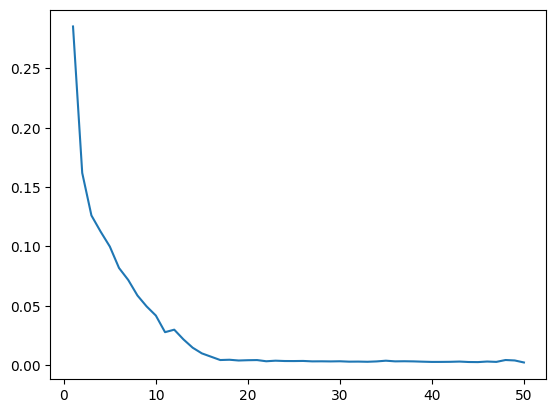

In [273]:
plt.plot(np.arange(1, n_epochs + 1), epoch_loss_values)
plt.show()

In [77]:
def make_predictions_w2v(model, df_test, batch_size, threshold, prints_b = True): 
    global W2V_IDX
    
    n_prints = 0
    predictions = []
    true_labels = []
    test_batches = split(df_test, batch_size)
    
    for batch in test_batches:
        batch_ix, seq_lengths = vectorize(batch['Message_filtered'].tolist(), W2V_IDX)
        seq_lengths = np.array(seq_lengths)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

        y_true = batch['Category'].tolist()

        y_pred = model(batch_ix, seq_lengths).cpu().detach().squeeze().numpy()
        y_pred = [int(pred.item() > threshold) for pred in y_pred]
        
        predictions.extend(y_pred)
        true_labels.extend(y_true)
        
        if prints_b:
            for true, pred, document in zip(y_true, y_pred, batch['Message']):
                if true == 1.0 and n_prints < 10:
                    print("prediction: {}".format(pred))
                    print("truth: {}".format(true))
                    print("message contains: {}".format(document))
                    print("\n" + "/////////////////////////////" + "\n")
                    n_prints += 1
        
    return true_labels, predictions

In [78]:
true_labels, predictions = make_predictions_w2v(model, df_test, batch_size=batch_size, threshold=0.5)

prediction: 1
truth: 1
message contains: Collect your VALENTINE'S weekend to PARIS inc Flight & Hotel + £200 Prize guaranteed! Text: PARIS to No: 69101. www.rtf.sphosting.com

/////////////////////////////

prediction: 1
truth: 1
message contains: Boltblue tones for 150p Reply POLY# or MONO# eg POLY3 1. Cha Cha Slide 2. Yeah 3. Slow Jamz 6. Toxic 8. Come With Me or STOP 4 more tones txt MORE

/////////////////////////////

prediction: 1
truth: 1
message contains: Sppok up ur mob with a Halloween collection of nokia logo&pic message plus a FREE eerie tone, txt CARD SPOOK to 8007

/////////////////////////////

prediction: 1
truth: 1
message contains: Get 3 Lions England tone, reply lionm 4 mono or lionp 4 poly. 4 more go 2 www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply

/////////////////////////////

prediction: 1
truth: 1
message contains: Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc a

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [278]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.61      0.75        33
           1       0.75      1.00      0.86        39

    accuracy                           0.82        72
   macro avg       0.88      0.80      0.81        72
weighted avg       0.86      0.82      0.81        72

0.8194444444444444


In [79]:
true_labels, predictions = make_predictions_w2v(model, df_train, batch_size=batch_size, threshold=0.5)

prediction: 1
truth: 1
message contains: UR awarded a City Break and could WIN a £200 Summer Shopping spree every WK. Txt STORE to 88039.SkilGme.TsCs087147403231Winawk!Age16+£1.50perWKsub

/////////////////////////////

prediction: 1
truth: 1
message contains: Romantic Paris. 2 nights, 2 flights from £79 Book now 4 next year. Call 08704439680Ts&Cs apply.

/////////////////////////////

prediction: 1
truth: 1
message contains: For ur chance to win a £250 wkly shopping spree TXT: SHOP to 80878. T's&C's www.txt-2-shop.com custcare 08715705022, 1x150p/wk

/////////////////////////////

prediction: 1
truth: 1
message contains: PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call 08719899230 Identifier Code: 41685 Expires 07/11/04

/////////////////////////////

prediction: 1
truth: 1
message contains: Welcome to UK-mobile-date this msg is FREE giving you free calling to 08719839835. Future mgs billed at 150p daily. To cancel send "go stop" to 89123

/////////

In [280]:
print(classification_report(true_labels, predictions))
print(accuracy_score(true_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      0.61      0.76       657
           1       0.74      1.00      0.85       702

    accuracy                           0.81      1359
   macro avg       0.87      0.81      0.80      1359
weighted avg       0.86      0.81      0.81      1359

0.8138337012509198


На тестових даних себе краще показувала модель з нашим кастомним вкладенням. 
Але була проблема у можливому overfitting на тренувальних даних.

Модель з існуючим вкладенням не має оверфітінгу, але має меншу точність для тестових даних.

Як висновок можна сказати, що краще брати існуючі інструменти і підлаштовувати їх під себе.
Це швидше, тому "дешевше"